###### Imports and Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

###### Functions

In [2]:
#Create a function for division to avoid dividing by 0 and getting infinite values
def percentchange(x, y):
    try:
        return round((x-y)*100/y, 2)
    except ZeroDivisionError:
        return 666
#Create a function for calculating real change
def realchange(x, y):
    return round(x-y, 2)
#Create a function for calculating population density
def populationdensity(x, y):
    try:
        return round(x/y, 2)
    except ZeroDivisionError:
        return 666

###### Census Bureau API Key

In [3]:
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'

# Project Introduction  

This notebook contains data preparation code for a peer communities analysis of Coopertown town, Tennessee. The goal is to get comparative information about fee structures in peer communities as Coopertown is rehashing their own. Because fee structures are partially determined by state government structures, this analysis is of all places in Tennessee. Data comes from the ACS 5-Year Estimates, TIGER files, and Economic Census Building Permits data series. Inputs include population, average household size, average drive time to work, land area, and number of residential building permits issued.

## American Community Survey Data

### Population  
Three most recent 5-Year Estimates that do not overlap:  
+ 2005-2009  
+ 2010-2014  
+ 2015-2019  

These will be used as a stand-alone inputs, and used to calculate real and percent change over the "short term" (10 years) and "long term" (15 years).

**Variable: B01003_001E**

### Average Household Size  
Average household size will be a way to factor in whether a community may be rural or urban. Rural areas tend to have larger households than urban areas.  

**Variable: B25010_001E**  

### Average Commute Time To Work  
This is from the ACS Subject Tables, so it will be in a different API call than the above data. This is average commute time for workers 16+ who do not work remotely. Coopertown identifies as a "bedroom town" where much of the labor force commute out of the area to work. This will be a way to factor in whether the dynamic is similar in other communities.  

**Variable: S0801_C01_046E**  

**Detailed Variables: https://api.census.gov/data/2019/acs/acs5/variables.html**  
**Subject Variables: https://api.census.gov/data/2019/acs/acs5/subject/variables.html**

In [4]:
#2019 5-Year Subject Table - travel time to work
url_str= 'https://api.census.gov/data/2019/acs/acs5/subject?key='+api_key
predicates= {}
get_vars= ["NAME", 'S0801_C01_046E'] #the only variable is total population
predicates["get"]= ",". join(get_vars)
predicates["for"]= "place:*" #all places
predicates["in"]= "state:47" #all states
data= requests.get(url_str, params= predicates)
col_names = ['Place', 'drive', 'StateFIPS', 'PlaceFIPS']
M=pd.DataFrame(columns=col_names, data=data.json()[1:])
print('Your API call is complete.')

Your API call is complete.


In [5]:
M.head()

,Place,drive,StateFIPS,PlaceFIPS
0,"Millersville city, Tennessee",31.2,47,48980
1,"Baneberry city, Tennessee",35.7,47,03078
2,"Lawrenceburg city, Tennessee",21.9,47,41340
3,"Three Way city, Tennessee",23.6,47,74100
4,"Colonial Heights CDP, Tennessee",21.7,47,16500


In [6]:
M['GEOID'] = M['StateFIPS'] + M['PlaceFIPS']

In [9]:
#list of the estimates in question to loop through
years = ['2009','2014','2019']
#for loop appending each year to the last
data_appended = []
for i in years:
    url_str= 'https://api.census.gov/data/{}/acs/acs5?key='.format(i)+api_key
    predicates= {}
    get_vars= ["NAME", "GEO_ID",'B01003_001E','B25010_001E']
    predicates["get"]= ",". join(get_vars)
    predicates["for"]= "place:*" #all places
    predicates["in"]= "state:47" #all states
    data= requests.get(url_str, params= predicates)
    col_names = ['Place', 'GEOID','totalpop','hhsize','StateFIPS', 'PlaceFIPS']
    data=pd.DataFrame(columns=col_names, data=data.json()[1:])
    data['Year'] = '{}'.format(i) 
    data_appended.append(data)
                        
data_appended = pd.concat(data_appended)
J = data_appended #calling this J so that we don't have to rerun this all the time                 
print('Your API call is complete.')

Your API call is complete.


In [8]:
#breaking this up and renaming our dataframe data
data = J.reset_index(drop=True)

In [9]:
data.head()

,Place,GEOID,totalpop,hhsize,StateFIPS,PlaceFIPS,Year
0,"Mount Carmel town, Tennessee",1600000US4750580,5356,2.44,47,50580,2009
1,"Mount Juliet city, Tennessee",1600000US4750780,20501,2.85,47,50780,2009
2,"Mount Pleasant city, Tennessee",1600000US4751080,4451,2.37,47,51080,2009
3,"Munford city, Tennessee",1600000US4751540,6304,2.45,47,51540,2009
4,"Murfreesboro city, Tennessee",1600000US4751560,97423,2.40,47,51560,2009


In [10]:
data['GEOID'] = data['StateFIPS']+data['PlaceFIPS']

In [11]:
#pivot - unpack index later
data = data.set_index(data.index).pivot(values = ['totalpop','hhsize'], index=['Place','GEOID','StateFIPS','PlaceFIPS'], columns = 'Year')

In [12]:
data.head()

totalpop             hhsize            
Year                                                       2009  2014  2019   2009  2014  2019
Place                      GEOID   StateFIPS PlaceFIPS                                        
Adams city, Tennessee      4700200 47        00200          612   836   602   2.58  2.97  2.87
Adamsville town, Tennessee 4700240 47        00240         2111  1909  2307   2.23  2.28  2.63
Alamo town, Tennessee      4700440 47        00440         2397  2423  2187   2.63  2.63  2.51
Alcoa city, Tennessee      4700540 47        00540         8613  8556  9561   2.39  2.30  2.49
Alexandria town, Tennessee 4700620 47        00620          919  1184  1002   2.58  2.81  2.52

In [13]:
data.columns = data.columns.values
data.columns = pd.MultiIndex.from_tuples(data.rename(columns={('totalpop', '2009'):('totalpop', '09pop'),('totalpop', '2014'):('totalpop', '14pop'), 
                                                         ('totalpop', '2019'):('totalpop', '19pop'),('hhsize', '2009'):('hhsize', '09hhsize'), 
                                                         ('hhsize', '2014'):('hhsize', '14hhsize'),('hhsize', '2019'):('hhsize', '19hhsize')}))

In [14]:
data.columns = data.columns.droplevel()

In [15]:
data.head(2)

,,,,09pop,14pop,19pop,09hhsize,14hhsize,19hhsize
Place,GEOID,StateFIPS,PlaceFIPS,,,,,,
"Adams city, Tennessee",4700200,47,00200,612,836,602,2.58,2.97,2.87
"Adamsville town, Tennessee",4700240,47,00240,2111,1909,2307,2.23,2.28,2.63


In [16]:
#unpack indices
data = data.reset_index()

In [17]:
data.head(2)

,Place,GEOID,StateFIPS,PlaceFIPS,09pop,14pop,19pop,09hhsize,14hhsize,19hhsize
0,"Adams city, Tennessee",4700200,47,00200,612,836,602,2.58,2.97,2.87
1,"Adamsville town, Tennessee",4700240,47,00240,2111,1909,2307,2.23,2.28,2.63


In [18]:
#just need current hhsize so drop 09 and 14 estimates
data = data.drop(columns = ['09hhsize','14hhsize'])

In [19]:
#now rename
data = data.rename(columns = {'19hhsize':'hhsize'})

In [20]:
data['GEOID'] = data['GEOID'].astype(str)
M['GEOID'] = M['GEOID'].astype(str)

In [21]:
data = pd.merge(data, M, on = 'GEOID')

In [22]:
data.head()

,Place_x,GEOID,StateFIPS_x,PlaceFIPS_x,09pop,14pop,19pop,hhsize,Place_y,drive,StateFIPS_y,PlaceFIPS_y
0,"Adams city, Tennessee",4700200,47,00200,612,836,602,2.87,"Adams city, Tennessee",34.8,47,00200
1,"Adamsville town, Tennessee",4700240,47,00240,2111,1909,2307,2.63,"Adamsville town, Tennessee",25.1,47,00240
2,"Alamo town, Tennessee",4700440,47,00440,2397,2423,2187,2.51,"Alamo town, Tennessee",19.0,47,00440
3,"Alcoa city, Tennessee",4700540,47,00540,8613,8556,9561,2.49,"Alcoa city, Tennessee",22.0,47,00540
4,"Alexandria town, Tennessee",4700620,47,00620,919,1184,1002,2.52,"Alexandria town, Tennessee",36.4,47,00620


In [23]:
data = data.drop(columns = ['Place_y', 'StateFIPS_y', 'PlaceFIPS_y'])

In [24]:
data = data.rename(columns = {'Place_x':'Place', 'PlaceFIPS_x':'PlaceFIPS','StateFIPS_x':'StateFIPS'})

In [25]:
CT = data.loc[data['GEOID'] == '4716980']
CT

,Place,GEOID,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive
83,"Coopertown town, Tennessee",4716980,47,16980,3342,4321,4496,2.79,33.8


In [26]:
#drop any rows with null values this shouldn't be the case for any communities we're concerned with
data = data.dropna()

In [27]:
#convert datatypes for qualifiers then mathematical operations
cols = ['09pop','14pop','19pop']
data[cols] = data[cols].astype(float)
data[cols] = data[cols].astype(int)

In [28]:
cols = ['hhsize','drive']
data[cols] = round(data[cols].astype(float),2)

In [29]:
#drop Places that had no population reported for any of the three 5 year periods and reset index again
data = data[data[['Place','GEOID','StateFIPS','PlaceFIPS','09pop','14pop','19pop','hhsize','drive']] != 0]
data = data.reset_index(drop=True)

In [30]:
#drop any rows with null values this shouldn't be the case for any communities we're concerned with
data = data.dropna()

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Place      374 non-null    object 
 1   GEOID      374 non-null    object 
 2   StateFIPS  374 non-null    object 
 3   PlaceFIPS  374 non-null    object 
 4   09pop      374 non-null    int32  
 5   14pop      374 non-null    int32  
 6   19pop      374 non-null    int32  
 7   hhsize     374 non-null    float64
 8   drive      374 non-null    float64
dtypes: float64(2), int32(3), object(4)
memory usage: 24.8+ KB


Dropping columns with null or 0 values for any of the 5 year periods leaves us with 374 places.

In [32]:
#call change functions
data['ST%'] = percentchange(data['19pop'], data['14pop']) #short-term percent change
data['ST'] = realchange(data['19pop'], data['14pop']) #short-term real change
data['LT%'] = percentchange(data['19pop'], data['09pop']) #long-term percent change
data['LT'] = realchange(data['19pop'], data['09pop']) #long-term real change

In [33]:
#check out Coopertown town
CT = data.loc[data['Place'] == 'Coopertown town, Tennessee']
CT

,Place,GEOID,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT
70,"Coopertown town, Tennessee",4716980,47,16980,3342,4321,4496,2.79,33.8,4.05,175,34.53,1154


In [34]:
#Split the Place name so that it doesn't contain the State, keep the State column just in case we want to look by State later so we won't have to just use the FIPS
name = data['Place'].str.split(pat = ',', expand=True)
data['Place'] = name[0]
data['State'] = name[1]

In [35]:
#Take out the CDPs, villages, and boroughs - this takes us down to 342
data = data[~data.Place.str.contains('CDP')]
data = data[~data.Place.str.contains('village')]
data = data[~data.Place.str.contains('borough')]

## Geography

Extract and append all of the state level place files from the Census TIGER database. Find this path here: https://www2.census.gov/geo/tiger/TIGER2019/PLACE/. The zip files are formatted so that the State FIPS codes distinguish them Tennessee's is used.

The areas are in square meters and will be converted to square miles.

In [36]:
url= 'https://www2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_47_place.zip'
geo = gpd.read_file(url)
print('Your geographic file is ready.')

Your geographic file is ready.


In [37]:
#drop all the noise or things that will be filled in by other dataframe when joined
geo = geo.drop(columns = ['LSAD','PCICBSA','STATEFP','PLACEFP','PLACENS','CLASSFP','PCINECTA','MTFCC','FUNCSTAT','INTPTLAT','INTPTLON'])

In [38]:
#convert the land area to square miles
geo['SQMILES'] = round(geo['ALAND']* 0.000000386102,2)

## Join ACS and Geography

In [39]:
data_geo = geo.merge(data, on = 'GEOID').reset_index(drop=True)

In [40]:
data_geo.head()

,GEOID,NAME,NAMELSAD,ALAND,AWATER,geometry,SQMILES,Place,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State
0,4724240,Enville,Enville town,3742521,0,"POLYGON ((-88.45060 35.39696, -88.45053 35.397...",1.44,Enville town,47,24240,181,226,168,2.75,34.4,-25.66,-58,-7.18,-13,Tennessee
1,4748920,Milledgeville,Milledgeville town,4162578,0,"POLYGON ((-88.38010 35.38286, -88.37993 35.382...",1.61,Milledgeville town,47,48920,337,226,297,2.32,37.0,31.42,71,-11.87,-40,Tennessee
2,4731490,Gruetli-Laager,Gruetli-Laager city,32831802,0,"POLYGON ((-85.70419 35.37807, -85.70386 35.377...",12.68,Gruetli-Laager city,47,31490,2035,1646,2429,3.25,31.3,47.57,783,19.36,394,Tennessee
3,4774880,Tracy City,Tracy City town,12058477,302368,"POLYGON ((-85.78324 35.25530, -85.78290 35.262...",4.66,Tracy City town,47,74880,1655,1697,1561,2.54,26.1,-8.01,-136,-5.68,-94,Tennessee
4,4756560,Palmer,Palmer town,12770064,0,"POLYGON ((-85.58601 35.36379, -85.58275 35.368...",4.93,Palmer town,47,56560,805,738,696,2.99,42.5,-5.69,-42,-13.54,-109,Tennessee


In [41]:
data_geo = data_geo.drop(columns = ['ALAND','AWATER','Place'])

In [42]:
data_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GEOID      342 non-null    object  
 1   NAME       342 non-null    object  
 2   NAMELSAD   342 non-null    object  
 3   geometry   342 non-null    geometry
 4   SQMILES    342 non-null    float64 
 5   StateFIPS  342 non-null    object  
 6   PlaceFIPS  342 non-null    object  
 7   09pop      342 non-null    int32   
 8   14pop      342 non-null    int32   
 9   19pop      342 non-null    int32   
 10  hhsize     342 non-null    float64 
 11  drive      342 non-null    float64 
 12  ST%        342 non-null    float64 
 13  ST         342 non-null    int32   
 14  LT%        342 non-null    float64 
 15  LT         342 non-null    int32   
 16  State      342 non-null    object  
dtypes: float64(5), geometry(1), int32(5), object(6)
memory usage: 38.9+ KB


In [43]:
#check out Coopertown town
CT = data_geo.loc[data_geo['GEOID'] == '4716980']
CT

,GEOID,NAME,NAMELSAD,geometry,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State
136,4716980,Coopertown,Coopertown town,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",31.58,47,16980,3342,4321,4496,2.79,33.8,4.05,175,34.53,1154,Tennessee


In [44]:
#use population density functions
data_geo['19density'] = populationdensity(data_geo['19pop'], data_geo['SQMILES']) #'05-'09 population density
data_geo['14density'] = populationdensity(data_geo['14pop'], data_geo['SQMILES']) #'10-'14 population density
data_geo['09density'] = populationdensity(data_geo['09pop'], data_geo['SQMILES']) #'15-'19 population density

In [45]:
#use real and percent change functions
data_geo['STDensity'] = realchange(data_geo['19density'], data_geo['14density']) #short-term real change in population density
data_geo['ST%Density'] = percentchange(data_geo['19density'], data_geo['14density']) #short-term percent change in population density
data_geo['LTDensity'] = realchange(data_geo['19density'], data_geo['09density']) #long-term real change in population density
data_geo['LT%Density'] = percentchange(data_geo['19density'], data_geo['09density']) #long-term percent change in population density

We've calculated everything now and it's safe to dropna here because we're really not concerned with communities that have no population or population density in any case. Above we've also ensured that Coopertown has none.

In [46]:
data_geo = data_geo.dropna()

In [47]:
data_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 342 entries, 0 to 341
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       342 non-null    object  
 1   NAME        342 non-null    object  
 2   NAMELSAD    342 non-null    object  
 3   geometry    342 non-null    geometry
 4   SQMILES     342 non-null    float64 
 5   StateFIPS   342 non-null    object  
 6   PlaceFIPS   342 non-null    object  
 7   09pop       342 non-null    int32   
 8   14pop       342 non-null    int32   
 9   19pop       342 non-null    int32   
 10  hhsize      342 non-null    float64 
 11  drive       342 non-null    float64 
 12  ST%         342 non-null    float64 
 13  ST          342 non-null    int32   
 14  LT%         342 non-null    float64 
 15  LT          342 non-null    int32   
 16  State       342 non-null    object  
 17  19density   342 non-null    float64 
 18  14density   342 non-null    float64 
 19  

In [48]:
#rename to df
df = data_geo.reset_index(drop=True)

## Economic Census Building Permits Data

Now we will pull the Economic Census permitting information to look at permitting rates and growth. Find the path here: https://www2.census.gov/econ/bps/Place/. 

In order to compare this to the ACS data reflecting '5-Year Estimates' will be created. However, because of limitations on how this data is formatted and provided, only reflecting "short-term" change will be calculated as collected data begins in 2010.

In [49]:
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']

In [50]:
#South Loop
data_appended = []
for i in years:
    url = 'https://www2.census.gov/econ/bps/Place/South%20Region/so{}a.txt'.format(i)
    t = requests.get(url).content
    col_names = ('SurveyDate','StateCode','6DigitID','CountyCode','CensusPlaceCode','PlaceFIPS','FIPSMCD','Pop','CSA','CBSA','Footnote','Central',
             'ZipPermitOffice','Region','Division','Numberof','Place','1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
             '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation') #set column names
    header = 2 #set to skip the header.. their column names sux
    #At this point decoded is not a file, it is a character string with the content from the web page. The next lines make it into a file.
    data = pd.read_csv(io.StringIO(t.decode('utf-8')), skiprows = header, 
                      header = None, names = col_names,skipinitialspace = True, 
                      index_col = False,dtype = str)
    data_appended.append(data)
    
data_appended = pd.concat(data_appended)
south = data_appended

print('Go ahead')
#Note that the error is because I am not parsing the last few columns because they are duplicates of the first set of permitting numbers.

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


Go ahead


In [51]:
south.head(2)

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
0,2010,01,001000,067,0005,00124,90009,2987,222,20020,NaN,NaN,36310,3,6,12,Abbeville,1,1,200000,0,0,0,0,0,0,0,0,0
1,2010,01,002000,073,0010,00460,91404,4965,142,13820,NaN,NaN,35005,3,6,12,Adamsville,1,1,312000,0,0,0,0,0,0,0,0,0


In [52]:
bp = south

In [53]:
bp = bp.loc[bp['StateCode'] == '47']

In [54]:
bp.head()

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
2737,2010,47,003000,109,0010,00240,90016,1983,999,99999,2,NaN,38310,3,6,12,Adamsville town,7,7,100857,0,0,0,0,0,0,0,0,0
2738,2010,47,005000,033,0015,00440,90024,2392,999,99999,NaN,NaN,38001,3,6,12,Alamo town,1,1,75000,0,0,0,0,0,0,0,0,0
2739,2010,47,007000,009,0020,00540,92136,7734,314,28940,NaN,NaN,37701,3,6,12,Alcoa,1,1,85000,0,0,0,0,0,0,0,0,0
2740,2010,47,009000,041,0025,00620,93440,814,999,99999,NaN,NaN,37012,3,6,12,Alexandria town,1,1,50000,0,0,0,0,0,0,0,0,0
2741,2010,47,011000,141,0030,00640,90792,2942,999,99999,2,NaN,38506,3,6,12,Algood,9,9,1086400,0,0,0,0,0,0,0,0,0


In [55]:
# #drop noise
# bp = bp.drop(columns = ['6DigitID','CountyCode','CensusPlaceCode','FIPSMCD','Pop','Region','CSA','Footnote','Central',
#                                                   'ZipPermitOffice','Region','Division','Numberof'])

In [56]:
#there are trailing zeroes on the place fips that we need to drop, so split them and take the first column as new value
doot = bp['PlaceFIPS'].str.split(pat = ' ', expand=True)
#doot[0]
#doot[1]

In [57]:
bp['PlaceFIPS'] = doot[0]

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [58]:
# #have checked, there are no leading or trailing zeroes here
# doop = bp['StateCode'].str.split(pat = ' ', expand=True)
# #doop[0]
# #doop[1]

In [59]:
#join the two now to create a GEOID that matches our other dataframe
bp['GEOID'] = bp['StateCode'] + bp['PlaceFIPS']

In [60]:
#count null values
bp.isna().sum()

SurveyDate            0
StateCode             0
6DigitID              0
CountyCode            0
CensusPlaceCode     583
PlaceFIPS           106
FIPSMCD             107
Pop                 160
CSA                   0
CBSA                  0
Footnote           2699
Central            3107
ZipPermitOffice       0
Region                0
Division              0
Numberof              0
Place                 0
1UBuildings           0
1UUnits               0
1UValuation           0
2UBuildings           0
2UUnits               0
2UValuation           0
3to4UBuildings        0
3to4UUnits            0
3to4UValuation        0
5UBuildings           0
5UUnits               0
5UValuation           0
GEOID               106
dtype: int64

drop geos with no GEOID

In [61]:
bp = bp.dropna(subset = ['GEOID'])

drop unneeded columns

In [62]:
#in group by we can drop StateCode, 6 DigitID, Census Place Code, PlaceFIPS, Pop, Footnote, Central, Zip Permit Office, Region, Division, and Numberof
bp = bp.drop(columns = ['StateCode','6DigitID','CensusPlaceCode','PlaceFIPS','Pop','Footnote','FIPSMCD','Central','ZipPermitOffice','Region','Division','Numberof'])

Calculate total permits issued.

In [63]:
cols = ['1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
        '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation']
bp[cols] = bp[cols].astype(float)

In [64]:
bp['totalunits'] = bp['1UUnits']+bp['2UUnits']+bp['3to4UUnits']+bp['5UUnits']
bp = bp.drop(columns = ['1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
                        '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation'])

In [65]:
if bp['Place'].str.contains('Coopertown').any():
    print('Coopertown is there')

Coopertown is there


Now let's fan out the SurveyDate like we did with the years above so it becomes easier to calculate "5-Year Estimates" and then change.

In [66]:
#this keeps all of the data and sets it to index which we will subsequently unpack back into columns
bp = bp.pivot_table(values = 'totalunits', index=['Place','GEOID','CBSA','CSA'], columns = 'SurveyDate')

In [67]:
bp.head()

SurveyDate                         2010  2011  2012  2013   2014   2015   2016   2017   2018  2019
Place           GEOID   CBSA  CSA                                                                 
Adamsville town 4700240 99999 999   7.0   6.0  13.0   1.0    1.0    1.0    1.0    1.0    1.0   1.0
Alamo town      4700440 27180 297   NaN   NaN   NaN   NaN    NaN    NaN    0.0    0.0    NaN   NaN
                              999   NaN   NaN   NaN   NaN    0.0    0.0    NaN    NaN    NaN   NaN
                        99999 999   1.0   0.0   0.0   0.0    NaN    NaN    NaN    NaN    NaN   NaN
Alcoa           4700540 28940 314   1.0  48.0  33.0  46.0  291.0  254.0  224.0  208.0  232.0   NaN

In [68]:
#unpack indices
bp = bp.reset_index()

In [69]:
if bp['Place'].str.contains('Coopertown').any():
    print('Coopertown is there')

Coopertown is there


Now reassign null values as zeroes and then calculate 5 year estimates, after this we can definitely drop rows with zero values.

In [70]:
#keep first values of: Place, CBSA, CSA
#sum all of the years
bp = bp.groupby('GEOID').agg({'Place': lambda x: x.iloc[0],'CBSA':lambda x: x.iloc[0],'CSA':lambda x: x.iloc[0], 
                             '2010':sum,'2011':sum,'2012':sum,'2013':sum,'2014':sum,'2015':sum,'2016':sum,'2017':sum,'2018':sum,'2019':sum})

In [71]:
#replace null values with 0
bp = bp.reset_index()
bp = bp.fillna(0)

In [72]:
bp['14permits'] = (bp['2010']+bp['2011']+bp['2012']+bp['2013']+bp['2014'])/5
bp['19permits'] = (bp['2015']+bp['2016']+bp['2017']+bp['2018']+bp['2019'])/5

In [73]:
bp.head(2)

SurveyDate,GEOID,Place,CBSA,CSA,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,14permits,19permits
0,4700000,Hartsville-Trousdale County,34980,400,0.0,0.0,0.0,0.0,72.0,96.0,89.0,107.0,146.0,121.0,14.4,111.8
1,4700240,Adamsville town,99999,999,7.0,6.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.6,1.0


In [74]:
bp = bp.drop(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])

In [75]:
bp['permreal'] = realchange(bp['19permits'], bp['14permits'])
bp['perm%'] = percentchange(bp['19permits'], bp['14permits'])

In [76]:
bp['StateFIPS'] = bp['GEOID'].str.slice(stop = 2)

In [77]:
TN = bp.loc[bp['StateFIPS'] == '47']
TN.head(3)

SurveyDate,GEOID,Place,CBSA,CSA,14permits,19permits,permreal,perm%,StateFIPS
0,4700000,Hartsville-Trousdale County,34980,400,14.4,111.8,97.4,676.39,47
1,4700240,Adamsville town,99999,999,5.6,1.0,-4.6,-82.14,47
2,4700440,Alamo town,27180,297,0.2,0.0,-0.2,-100.00,47


In [78]:
TN = TN.drop(columns = 'StateFIPS')

In [79]:
#examine the permitting data
TN.to_csv('../data/TNpermitdata.csv', index = False)

## Join all together

In [80]:
TN['GEOID'] = TN['GEOID'].astype(str)
data_geo['GEOID'] = data_geo['GEOID'].astype(str)

In [81]:
total = pd.merge(data_geo, TN, on = 'GEOID', how = 'inner').reset_index(drop=True)

In [82]:
total.head()

,GEOID,NAME,NAMELSAD,geometry,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,CSA,14permits,19permits,permreal,perm%
0,4731490,Gruetli-Laager,Gruetli-Laager city,"POLYGON ((-85.70419 35.37807, -85.70386 35.377...",12.68,47,31490,2035,1646,2429,3.25,31.3,47.57,783,19.36,394,Tennessee,191.56,129.81,160.49,61.75,47.57,31.07,19.36,Gruetli-Laager,99999,999,0.0,0.0,0.0,NaN
1,4774880,Tracy City,Tracy City town,"POLYGON ((-85.78324 35.25530, -85.78290 35.262...",4.66,47,74880,1655,1697,1561,2.54,26.1,-8.01,-136,-5.68,-94,Tennessee,334.98,364.16,355.15,-29.18,-8.01,-20.17,-5.68,Tracy City town,99999,999,0.2,0.0,-0.2,-100.00
2,4722180,Dyer,Dyer city,"POLYGON ((-89.00927 36.06839, -89.00926 36.069...",2.29,47,22180,2744,2335,2791,2.54,27.9,19.53,456,1.71,47,Tennessee,1218.78,1019.65,1198.25,199.13,19.53,20.53,1.71,Dyer,27180,297,1.8,4.8,3.0,166.67
3,4769320,Smithville,Smithville city,"POLYGON ((-85.85567 35.96583, -85.85408 35.965...",5.85,47,69320,4304,4587,4711,2.76,25.4,2.70,124,9.46,407,Tennessee,805.30,784.10,735.73,21.20,2.70,69.57,9.46,Smithville,99999,999,6.0,20.2,14.2,236.67
4,4753580,Normandy,Normandy town,"POLYGON ((-86.26221 35.45202, -86.26205 35.452...",0.24,47,53580,203,92,145,3.02,18.2,57.61,53,-28.57,-58,Tennessee,604.17,383.33,845.83,220.84,57.61,-241.66,-28.57,Normandy town,99999,999,0.2,0.0,-0.2,-100.00


In [83]:
total.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       280 non-null    object  
 1   NAME        280 non-null    object  
 2   NAMELSAD    280 non-null    object  
 3   geometry    280 non-null    geometry
 4   SQMILES     280 non-null    float64 
 5   StateFIPS   280 non-null    object  
 6   PlaceFIPS   280 non-null    object  
 7   09pop       280 non-null    int32   
 8   14pop       280 non-null    int32   
 9   19pop       280 non-null    int32   
 10  hhsize      280 non-null    float64 
 11  drive       280 non-null    float64 
 12  ST%         280 non-null    float64 
 13  ST          280 non-null    int32   
 14  LT%         280 non-null    float64 
 15  LT          280 non-null    int32   
 16  State       280 non-null    object  
 17  19density   280 non-null    float64 
 18  14density   280 non-null    float64 
 19  

## Remove outliers and set some parameters before the cluster analysis. 

Cluster analysis performs at its best when extreme outliers are removed so that the process can identify nuanced differences in a more similar group of data. This can be though of as creating a group via enforcing variable parameters in which we would be interested in seeing peers instead of using the algorithm to create said group. In order to be relevant, Coopertown's cluster would need to be identified out of a group of communities that are somewhat similar to Coopertown already so that the algorithm can find the closest peers within that group. The following parameters are enforced:  

+ hhsize - cut out any less than 1 (pure nonsensical outliers)
+ population - cut out any less than 1,000 or more than 10,000  
+ population change - cut out any with no growth  

In [89]:
CT = total.loc[total['GEOID'] == '4716980']
CT

,GEOID,NAME,NAMELSAD,geometry,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,CSA,14permits,19permits,permreal,perm%
109,4716980,Coopertown,Coopertown town,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",31.58,47,16980,3342,4321,4496,2.79,33.8,4.05,175,34.53,1154,Tennessee,142.37,136.83,105.83,5.54,4.05,36.54,34.53,Coopertown town,34980,400,6.0,21.8,15.8,263.33


In [90]:
df = total.reset_index(drop=True)

In [91]:
#drop the geos with hh size less than 1
df = df.loc[df['hhsize'] > 1]

In [92]:
#drop the geos with currentpop less than 100 and greater than 10,000
df = df.loc[df['19pop'] > 100]
df = df.loc[df['19pop'] < 15000]

In [93]:
#drop the geos without positive growth
df = df.loc[df['ST%'] > 0]
df = df.loc[df['LT%'] > 0]

In [94]:
# #BOTTOM SORT
# df.sort_values('hhsize', ascending = True).head()

In [95]:
# #TOP SORT
# df.sort_values('drive', ascending = False).head()

# Scatterplots: Examining Data Relationships

Text(0.5, 1.0, '15 Year % Population Growth vs % Pop Density Growth')

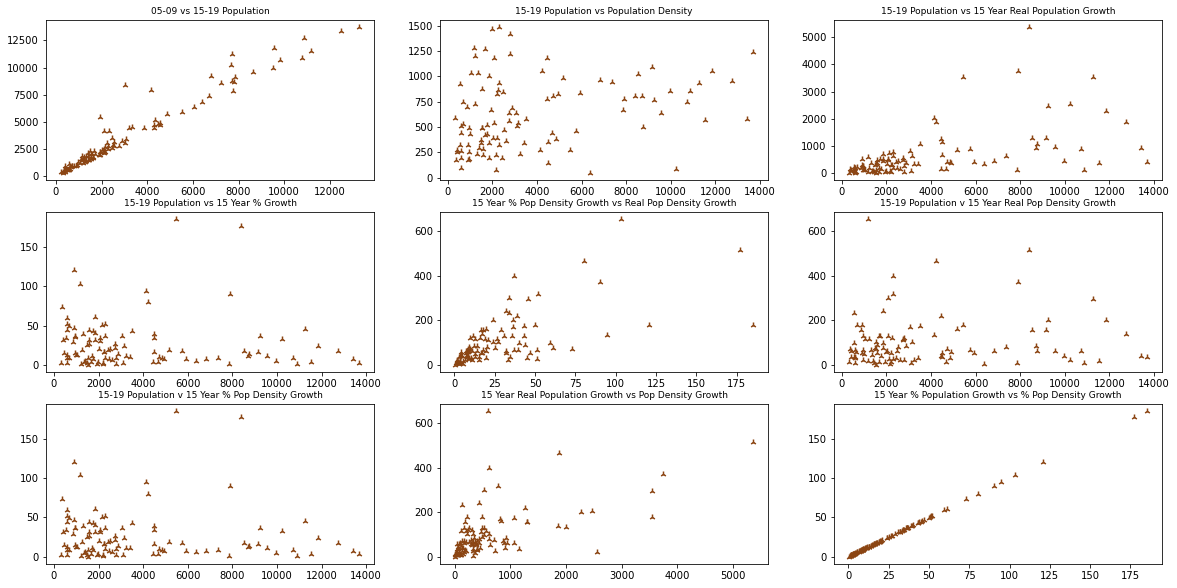

In [97]:
#long term just population
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['09pop'], df['19pop'], color='saddlebrown', marker = '2')
axs[0,0].set_title("05-09 vs 15-19 Population", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['19density'], color='saddlebrown', marker = '2')
axs[0,1].set_title("15-19 Population vs Population Density", fontsize = 9)
axs[0,2].scatter(df['19pop'], df['LT'], color='saddlebrown', marker = '2')
axs[0,2].set_title("15-19 Population vs 15 Year Real Population Growth", fontsize = 9)
axs[1,0].scatter(df['19pop'], df['LT%'], color='saddlebrown', marker = '2')
axs[1,0].set_title("15-19 Population vs 15 Year % Growth", fontsize = 9)
axs[1,1].scatter(df['LT%Density'], df['LTDensity'], color='saddlebrown', marker = '2')
axs[1,1].set_title("15 Year % Pop Density Growth vs Real Pop Density Growth", fontsize = 9)
axs[1,2].scatter(df['19pop'], df['LTDensity'], color='saddlebrown', marker = '2')
axs[1,2].set_title("15-19 Population v 15 Year Real Pop Density Growth", fontsize = 9)
axs[2,0].scatter(df['19pop'], df['LT%Density'], color='saddlebrown', marker = '2')
axs[2,0].set_title("15-19 Population v 15 Year % Pop Density Growth", fontsize = 9)
axs[2,1].scatter(df['LT'], df['LTDensity'], color='saddlebrown', marker = '2')
axs[2,1].set_title("15 Year Real Population Growth vs Pop Density Growth", fontsize = 9)
axs[2,2].scatter(df['LT%'], df['LT%Density'], color='saddlebrown', marker = '2')
axs[2,2].set_title("15 Year % Population Growth vs % Pop Density Growth", fontsize = 9)

Text(0.5, 1.0, 'Drive LTD%')

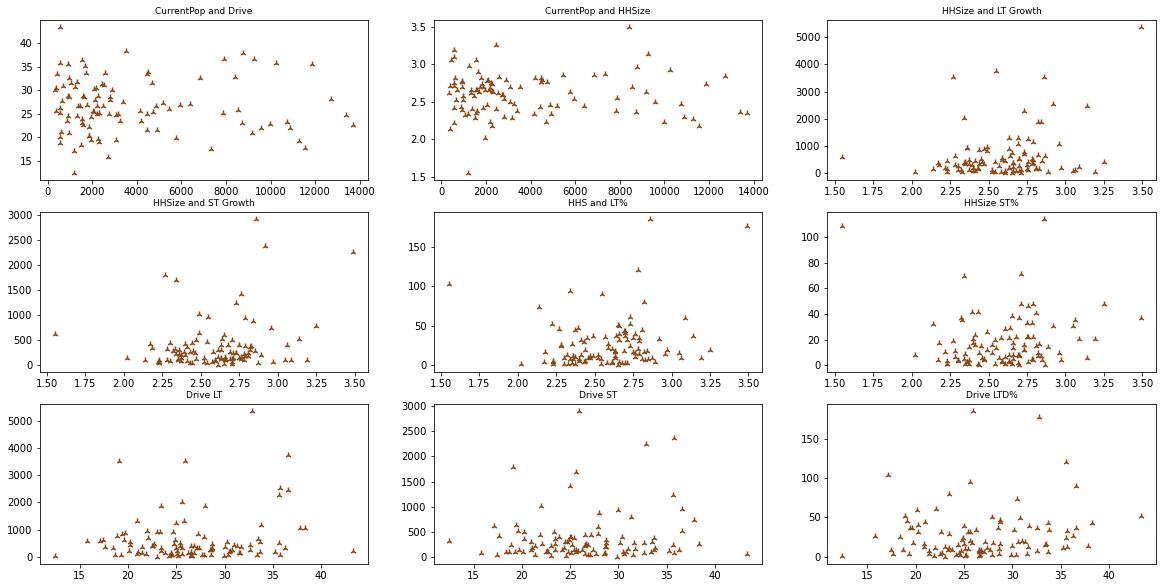

In [98]:
#population with other measures
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['19pop'], df['drive'], color='saddlebrown', marker = '2')
axs[0,0].set_title("CurrentPop and Drive", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['hhsize'], color='saddlebrown', marker = '2')
axs[0,1].set_title("CurrentPop and HHSize", fontsize = 9)
axs[0,2].scatter(df['hhsize'], df['LT'], color='saddlebrown', marker = '2')
axs[0,2].set_title("HHSize and LT Growth", fontsize = 9)
axs[1,0].scatter(df['hhsize'], df['ST'], color='saddlebrown', marker = '2')
axs[1,0].set_title("HHSize and ST Growth", fontsize = 9)
axs[1,1].scatter(df['hhsize'], df['LT%'], color='saddlebrown', marker = '2')
axs[1,1].set_title("HHS and LT%", fontsize = 9)
axs[1,2].scatter(df['hhsize'], df['ST%'], color='saddlebrown', marker = '2')
axs[1,2].set_title("HHSize ST%", fontsize = 9)
axs[2,0].scatter(df['drive'], df['LT'], color='saddlebrown', marker = '2')
axs[2,0].set_title("Drive LT", fontsize = 9)
axs[2,1].scatter(df['drive'], df['ST'], color='saddlebrown', marker = '2')
axs[2,1].set_title("Drive ST", fontsize = 9)
axs[2,2].scatter(df['drive'], df['LT%'], color='saddlebrown', marker = '2')
axs[2,2].set_title("Drive LTD%", fontsize = 9)

Text(0.5, 1.0, 'ST%Growth STDensity%Growth')

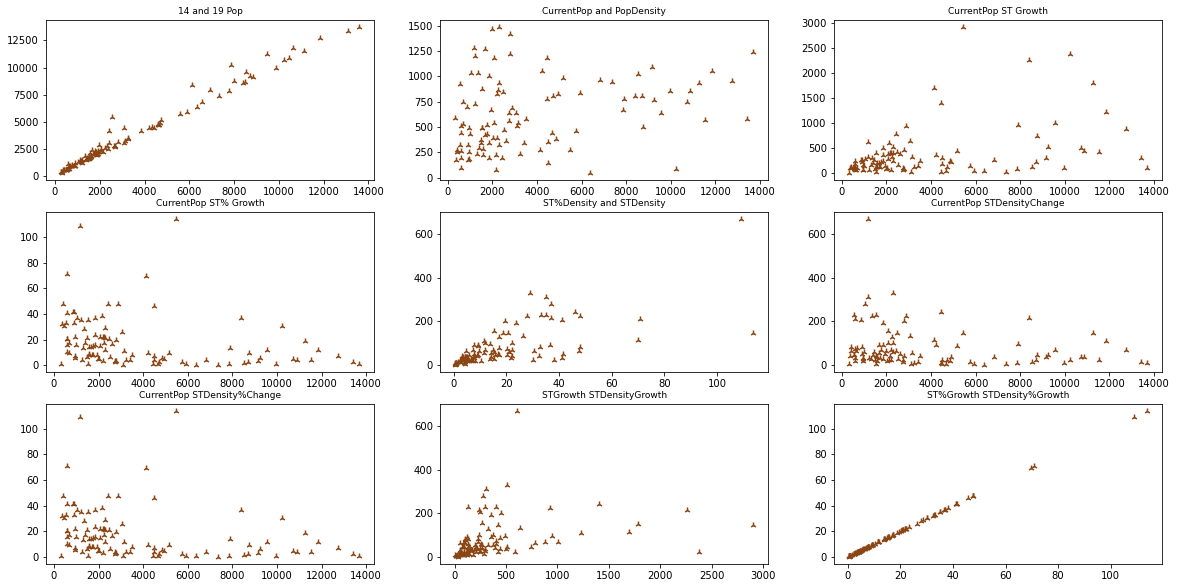

In [105]:
#short term
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['14pop'], df['19pop'], color='saddlebrown', marker = '2')
axs[0,0].set_title("14 and 19 Pop", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['19density'], color='saddlebrown', marker = '2')
axs[0,1].set_title("CurrentPop and PopDensity", fontsize = 9)
axs[0,2].scatter(df['19pop'], df['ST'], color='saddlebrown', marker = '2')
axs[0,2].set_title("CurrentPop ST Growth", fontsize = 9)
axs[1,0].scatter(df['19pop'], df['ST%'], color='saddlebrown', marker = '2')
axs[1,0].set_title("CurrentPop ST% Growth", fontsize = 9)
axs[1,1].scatter(df['ST%Density'], df['STDensity'], color='saddlebrown', marker = '2')
axs[1,1].set_title("ST%Density and STDensity", fontsize = 9)
axs[1,2].scatter(df['19pop'], df['STDensity'], color='saddlebrown', marker = '2')
axs[1,2].set_title("CurrentPop STDensityChange", fontsize = 9)
axs[2,0].scatter(df['19pop'], df['ST%Density'], color='saddlebrown', marker = '2')
axs[2,0].set_title("CurrentPop STDensity%Change", fontsize = 9)
axs[2,1].scatter(df['ST'], df['STDensity'], color='saddlebrown', marker = '2')
axs[2,1].set_title("STGrowth STDensityGrowth", fontsize = 9)
axs[2,2].scatter(df['ST%'], df['ST%Density'], color='saddlebrown', marker = '2')
axs[2,2].set_title("ST%Growth STDensity%Growth", fontsize = 9)

Text(0.5, 1.0, 'Drive and % Change Permits')

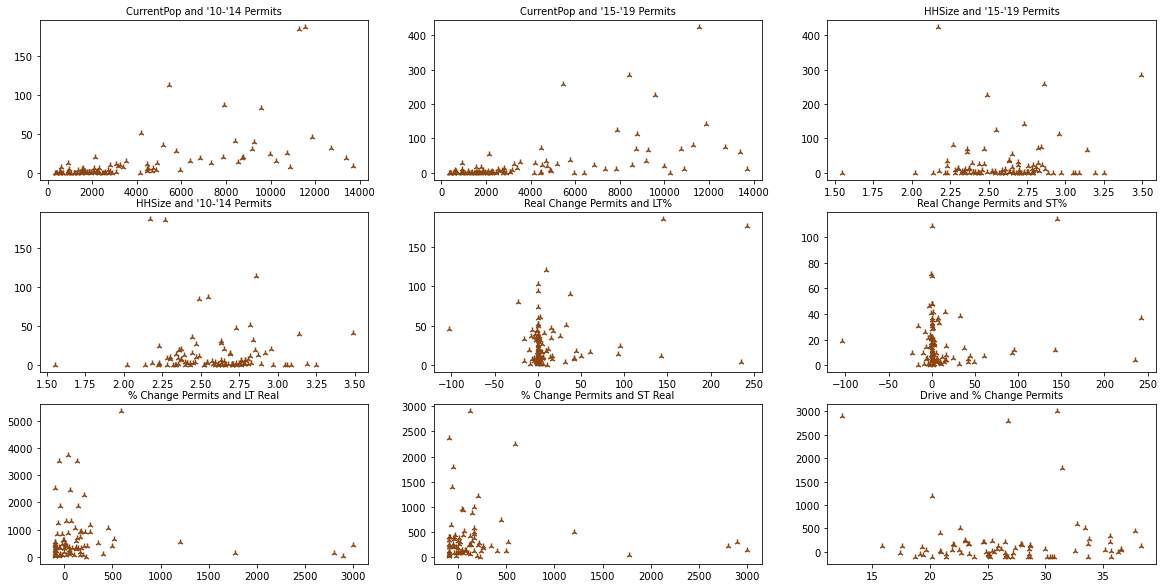

In [286]:
#permitting
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['19pop'], df['14permits'], color='saddlebrown', marker = '2')
axs[0,0].set_title("CurrentPop and '10-'14 Permits", fontsize = 9, font = 'helvetica')
axs[0,1].scatter(df['19pop'], df['19permits'], color='saddlebrown', marker = '2')
axs[0,1].set_title("CurrentPop and '15-'19 Permits", fontsize = 9, font = 'helvetica')
axs[0,2].scatter(df['hhsize'], df['19permits'], color='saddlebrown', marker = '2')
axs[0,2].set_title("HHSize and '15-'19 Permits", fontsize = 9, font = 'helvetica')
axs[1,0].scatter(df['hhsize'], df['14permits'], color='saddlebrown', marker = '2')
axs[1,0].set_title("HHSize and '10-'14 Permits", fontsize = 9, font = 'helvetica')
axs[1,1].scatter(df['permreal'], df['LT%'], color='saddlebrown', marker = '2')
axs[1,1].set_title("Real Change Permits and LT%", fontsize = 9, font = 'helvetica')
axs[1,2].scatter(df['permreal'], df['ST%'], color='saddlebrown', marker = '2')
axs[1,2].set_title("Real Change Permits and ST%", fontsize = 9, font = 'helvetica')
axs[2,0].scatter(df['perm%'], df['LT'], color='saddlebrown', marker = '2')
axs[2,0].set_title("% Change Permits and LT Real", fontsize = 9, font = 'helvetica')
axs[2,1].scatter(df['perm%'], df['ST'], color='saddlebrown', marker = '2')
axs[2,1].set_title("% Change Permits and ST Real", fontsize = 9, font = 'helvetica')
axs[2,2].scatter(df['drive'], df['perm%'], color='saddlebrown', marker = '2')
axs[2,2].set_title("Drive and % Change Permits", fontsize = 9, font = 'helvetica')

In [100]:
df = df.reset_index(drop=True)

In [101]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       105 non-null    object  
 1   NAME        105 non-null    object  
 2   NAMELSAD    105 non-null    object  
 3   geometry    105 non-null    geometry
 4   SQMILES     105 non-null    float64 
 5   StateFIPS   105 non-null    object  
 6   PlaceFIPS   105 non-null    object  
 7   09pop       105 non-null    int32   
 8   14pop       105 non-null    int32   
 9   19pop       105 non-null    int32   
 10  hhsize      105 non-null    float64 
 11  drive       105 non-null    float64 
 12  ST%         105 non-null    float64 
 13  ST          105 non-null    int32   
 14  LT%         105 non-null    float64 
 15  LT          105 non-null    int32   
 16  State       105 non-null    object  
 17  19density   105 non-null    float64 
 18  14density   105 non-null    float64 
 19  

In [103]:
df.to_file('../data/geo/TN.shp')

Now we finish with an index-ordered dataframe with multiple numeric columns containing no null or zero values, perfect for scikit learn and its k means clustering algorithms.